## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print("0 if gpu: \n", device)
net.to(device)
    
print('\n', net)

0 if gpu: 
 cuda:0

 Net(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.35)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((240,240)), 
                                     RandomCrop((224,224)),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 64

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images
from torch.autograd import Variable

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = Variable(images.type(torch.cuda.FloatTensor)) ## turn to cuda for gpu

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

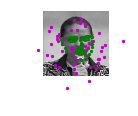

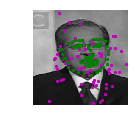

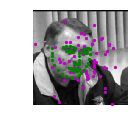

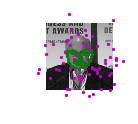

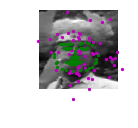

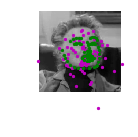

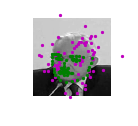

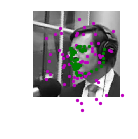

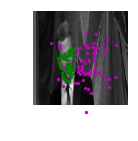

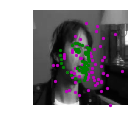

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss(reduce=True)

optimizer = optim.Adam(net.parameters())

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_online.pt'

# load net to renew training 
net.load_state_dict(torch.load('saved_models/keypoints_model_last.pt'))
print(net)

Net(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.35)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d

In [27]:
# training loop
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

n_epochs = 500# number of epochs to train model

# save epoch losses for plotting
train_losses = [] 
test_losses = []

min_test_loss = np.inf # minimum loss place holder
min_train_loss = np.inf # minimum loss place holder

for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train()    # set network to train mode    
    running_train_loss = 0.0
    
    # train on batches of data, assumes you already have train_loader
    for batch_i, train_data in enumerate(train_loader):
        
        # torch.set_default_tensor_type('torch.FloatTensor')
        # get the input images and their corresponding labels
        images = train_data['image']
        key_pts = train_data['keypoints']        
        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)
        # convert variables to cuda floats for regression loss
        key_pts = key_pts.type(torch.cuda.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)
        # forward pass to get outputs
        output_pts = net(images)
        # calculate the loss between predicted and target keypoints
        loss = criterion(output_pts, key_pts)
        # zero the parameter (weight) gradients
        optimizer.zero_grad()      
        # backward pass to calculate the weight gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # print loss statistics
        running_train_loss += loss.item()
        
    # calculate and save train loss,
    epoch_train_loss = running_train_loss / (batch_i*(len(train_loader)-1))
    train_losses.append(epoch_train_loss)
    
    # calculate and save test loss, set network to evaluate
    running_test_loss = 0.0
    net.eval() # set network to evaluate
    
    for batch_i, test_data in enumerate(test_loader):
            test_images = test_data['image'] # get the inputs images 
            test_key_pts = test_data['keypoints'] # get image keypoints
            test_key_pts = key_pts.view(key_pts.size(0), -1) 
            # convert to cuda for comparison
            test_key_pts = test_key_pts.cuda().requires_grad_(False)
            test_images = images.cuda().requires_grad_(False) 
            # forward pass to get outputs 
            test_outputs = net(test_images)
            test_loss = criterion(test_outputs, test_key_pts) # calculate test loss
            running_test_loss += test_loss.item()
        
    
    # calculate and save epoch test loss
    epoch_test_loss = running_test_loss / (batch_i*(len(test_loader)-1))  
    test_losses.append(epoch_test_loss)
    # delete variables to save memory
    del test_data, batch_i, test_images, test_key_pts, test_outputs, test_loss, running_test_loss
    
    # Patience check: break if minimum loss has not improved in last 21 epochs
    if(min_train_loss < np.min(train_losses[-21:])): 
        print('Patience level exhausted')
        break
        
    if (epoch_train_loss < min_train_loss):
        min_train_loss = epoch_train_loss  # set new minimum train loss
        
    # keep track of best model 
    if (epoch_test_loss < min_test_loss): 
        torch.save(net.state_dict(), model_dir+model_name) # save model with best test loss
        min_test_loss = epoch_test_loss  # set new minimum test loss
        
    print('Epoch: {:3.0f}|| Train Loss: {:.6f}, Test Loss: {:.6f}, Min Loss: {:.6f}'.format(epoch + 1, epoch_train_loss, epoch_test_loss, min_test_loss))
    
print('Finished Training')

Epoch:   1|| Train Loss: 0.000750, Test Loss: 0.002639, Min Loss: 0.002639
Epoch:   2|| Train Loss: 0.000739, Test Loss: 0.003678, Min Loss: 0.002639
Epoch:   3|| Train Loss: 0.000736, Test Loss: 0.002723, Min Loss: 0.002639
Epoch:   4|| Train Loss: 0.000751, Test Loss: 0.007380, Min Loss: 0.002639
Epoch:   5|| Train Loss: 0.000743, Test Loss: 0.002908, Min Loss: 0.002639
Epoch:   6|| Train Loss: 0.000748, Test Loss: 0.005102, Min Loss: 0.002639
Epoch:   7|| Train Loss: 0.000753, Test Loss: 0.005877, Min Loss: 0.002639
Epoch:   8|| Train Loss: 0.000750, Test Loss: 0.002169, Min Loss: 0.002169
Epoch:   9|| Train Loss: 0.000720, Test Loss: 0.001799, Min Loss: 0.001799
Epoch:  10|| Train Loss: 0.000738, Test Loss: 0.004681, Min Loss: 0.001799
Epoch:  11|| Train Loss: 0.000755, Test Loss: 0.006586, Min Loss: 0.001799
Epoch:  12|| Train Loss: 0.000733, Test Loss: 0.001775, Min Loss: 0.001775
Epoch:  13|| Train Loss: 0.000719, Test Loss: 0.002726, Min Loss: 0.001775
Epoch:  14|| Train Loss: 

Epoch: 111|| Train Loss: 0.000105, Test Loss: 0.000189, Min Loss: 0.000110
Epoch: 112|| Train Loss: 0.000103, Test Loss: 0.000142, Min Loss: 0.000110
Epoch: 113|| Train Loss: 0.000107, Test Loss: 0.000188, Min Loss: 0.000110
Epoch: 114|| Train Loss: 0.000106, Test Loss: 0.000114, Min Loss: 0.000110
Epoch: 115|| Train Loss: 0.000101, Test Loss: 0.000148, Min Loss: 0.000110
Epoch: 116|| Train Loss: 0.000099, Test Loss: 0.000171, Min Loss: 0.000110
Epoch: 117|| Train Loss: 0.000099, Test Loss: 0.000150, Min Loss: 0.000110
Epoch: 118|| Train Loss: 0.000111, Test Loss: 0.000271, Min Loss: 0.000110


Process Process-1727:
Process Process-1728:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-1726:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessin

KeyboardInterrupt: 

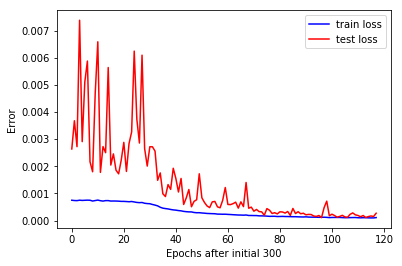

In [55]:
# plot train and test losses
plt.plot(train_losses, 'b')
plt.plot(test_losses, 'r')
plt.legend(('train loss', 'test loss'))
plt.xlabel('Epochs after initial 300')
plt.ylabel('Error')
plt.show()

In [29]:
## save the last model
model_dir = 'saved_models/'
model_name = 'keypoints_model_last.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [13]:
# load in trained model
net.load_state_dict(torch.load('saved_models/keypoints_model_last.pt'))
net.eval()
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


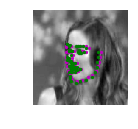

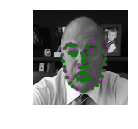

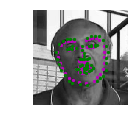

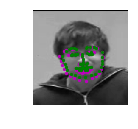

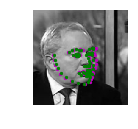

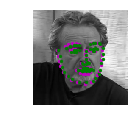

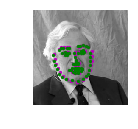

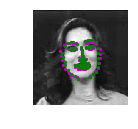

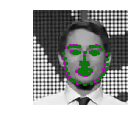

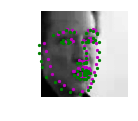

In [14]:
## TODO: visualize your test output

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [22]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_last.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)
# net.load_state_dict(torch.load(model_dir+model_name))

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

I used the Adam optimization and the Huber loss, or SmoothL1 loss function. Due to limits of personal compute power, experimenting with multiple optimizers was impractical. The Adam optimization was chosen when personal investigation into which optimizer was best for deep convolutional networks all too frequently led to recommendations to use the Adam optimizer -- even by Andrej Karpathy in his [Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition].(http://cs231n.github.io/neural-networks-3/#second). 
The SmoothL1Loss function was chosen over other regression loss functions, such as MSE and RMSE, for two main reasons: to prevent exploding gradients while training and to make our learning updates less sensitive to outliers. For the nature of our regression problem, where facial keypoints in an image can vary significantly, and that we are regressing 136 values, the SmoothL1Loss function allowed our model to learn consistently throughout training.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The first architecture I implemented was the NamishNet model [from the recommened paper](https://arxiv.org/pdf/1710.00977.pdf), but after 300 epochs of training this model did not converge to a good result as observed in the test images, though it appeared to have a very low training error. The model seemed to be overfitting, train error was significantly lower than testing error and training error was increasing consistently but testing error was decreasing negligbly. Thus to ameliorate the model's overfitting, I included both dropout and batch normalization in all convolution and fully connected layers. Batch normalization was applied before activation in convolutional layers and after activation in fully connected layers, but always before the dropout layer. P values of .35 and 4 for dropout were used after convolutional and fully connected layers, respectively.

After adding dropout and batch normalization to all layers, the model trained incredibly slow. Thus to maintain the dropout and batch normalization layers, I decreased the number of parameters by adding a global average pooling layer to the 4th convolutional layer. I trained this model for 300 epochs but the training loss went down very slowly and the test loss was erratic. I assumed the global average pooling took away too much of the complexity of the model. Thus I aimed to improve the model's complexity, and thus predictive power (albeit with diminishing returns), while still keeping batch normalization and dropout in each layer as well as keeping the model parameters low.

In the end, I added two more convolutional layers for a total of 6 convolutional layers, ending with a global average pooling layer -- for a total of 1024 final convolution output channels pooled(averaged) to one value for each channel.
These 1024 channels were flattened and fed into 2 fully connected layers of size 1024 and 1000, and finally to the output linear layer. I trained this final model for 300 epochs and observed that the training and testing results decreased constitently, and the visualizations of the test set showed the model was learning the ground key point, which solidified the choice of the architecture.


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

Considering the model trained on a set of 3462 images, and as well that it is optimal to select a batch size of a power of 2 --for efficiency  reasons of binary memory-- the most reasonable options for batch size were 32, 64 and 128. I chose batch size of 64, which gave 54 batches per epoch and thus the model updates the weights 54 times per training epoch. Between all the batch size choices, 64 seemed to be the most appropriate for our dataset of size 3462 -- updates were not too frequent per epch as batches of 32 (108 total) would be and not too delayed weight updates per epoch for batches of 128 (27 total).

As for number of epochs, I trained the model for 300 epochs and then saved the weights and tested the model to see the results. When I observed the model results for 300 epochs were satisfactory, both training/testing losses and test image visualizations showed merit for further training, I renewed training the model and let training continue until no improvement was seen over minimum testing error in 21 epochs, which was 118 epochs (computed over the entire testset at each epoch). The total number of training epochs used to train the model was 448. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.5041274  -0.51019186 -0.04844206]
 [ 0.09919941 -0.8110718   0.5062178 ]
 [ 0.5211983   0.6172418  -0.27518263]]
(3, 3)


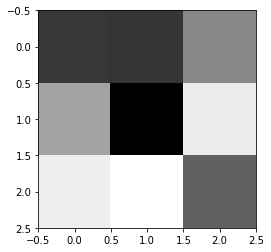

In [62]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv_layer1[0].weight.data # used sequential type

w = weights1.detach().cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

[[-4.6621597e-01 -6.2173247e-01 -3.5321227e-01]
 [ 5.9098190e-01  1.1336657e-01  2.6275057e-01]
 [ 4.5190332e-04  2.8118020e-01  1.4809158e-01]]


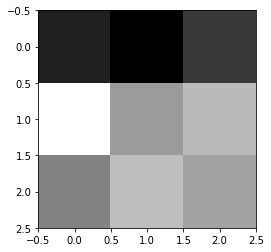

In [84]:
# filter to be used on test_image
test_filter = net.conv_layer1[0].weight.data # used sequential type
test_filter = test_filter.detach().cpu().numpy()
filter_index = 22
print(test_filter[filter_index][0])
plt.imshow(test_filter[filter_index][0], cmap='gray')
%clear

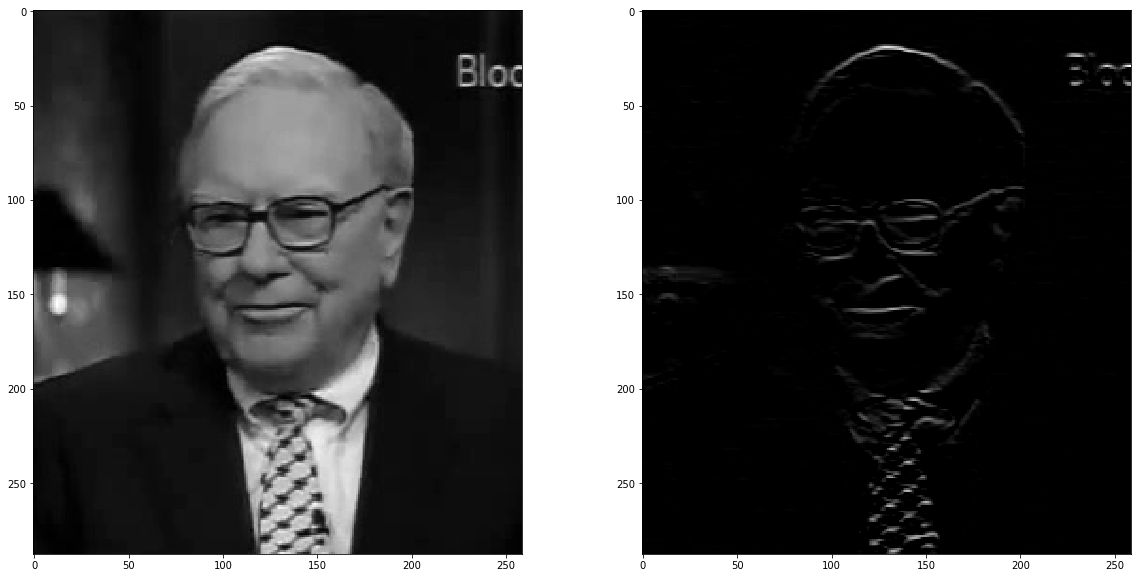

In [82]:
import matplotlib.image as mpimg
import os
import cv2

##TODO: load in and display any image from the transformed test dataset
image = mpimg.imread(os.path.join('data/test/Warren_Buffett_31.jpg'))
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered_image = cv2.filter2D(gray, -1, test_filter[filter_index][0])

# plot both gray image and filterd image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(gray, cmap='gray')
ax2.imshow(filtered_image, cmap='gray')
%clear

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:  This filter detects intense horizontal lines. As we observe in the the image, the filter delineates only the horizontal edges wiht very sharp contrast: from Warren Buffet's glasses, Buffet's lip line, the top of head and the super cool tie pattern (Buffet's got style!) and even the Bloomberg header. We note as well the filter weights are very low, all weights being less than 0, reinforcing that this is a filter specific for detection of sharp horizontal edges.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!